# Setup 



In [6]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Rea

In [7]:
!pip install vizdoom
!pip install ray 
!pip install ray['rllib']
!pip install Ipython --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached vizdoom-1.1.13.tar.gz (15.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for vizdoom: filename=vizdoom-1.1.13-cp37-cp37m-linux_x86_64.whl size=14101149 sha256=3b5fa9cc3f540cfa0968321bedae0d07e43749293c852d06291ca1d56580af00
  Stored in directory: /root/.cache/pip/wheels/ac/37/ae/8e648023f66bb4c473701f94ce126032ff39ad9759ca0645a7
Successfully built vizdoom
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Mounted at /content/drive


'/content/drive/MyDrive/GitHub/INM363-Project'

In [4]:
#sys.path

In [8]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [9]:
from ray.tune.registry import register_env
import gym
import ray
import ray.rllib.agents.ppo as ppo
import shutil
import torch

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Create and restore agent from checkpoint

In [11]:

ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")


Shutdown ray


2022-09-16 15:52:38,855	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


In [12]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False 
config['in_evaluation'] = True


#config["horizon"] = 50
agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

2022-09-16 15:52:46,554	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-16 15:52:46,558	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


(RolloutWorker pid=10000) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=10000) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
(RolloutWorker pid=10000) episode timeout: 400
(RolloutWorker pid=10000) screen resolution: 320X240


(RolloutWorker pid=10000) 2022-09-16 15:52:53,587	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-16 15:53:04,617	INFO trainable.py:164 -- Trainable.setup took 18.064 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-16 15:53:04,625	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [13]:
# examine the trained policy
policy = agent.get_policy()
model = policy.model


#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')
#,
#               config_file="custom\\very_dense_reward.cfg",
#                scenario_file="custom/test/easy_dense_reward_rs.wad") 
#               scenario_file="custom/test/dense_reward_fixed_start.wad") 

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 400
screen resolution: 320X240


In [32]:
#restore agent from checkpoint 
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense"
chkpt_dir = 'checkpoint_000080'

chkpt_file = chkpt_root + '/' + chkpt_dir 
print(chkpt_file)


/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000080


In [33]:
agent.restore(chkpt_file)

2022-09-16 15:55:35,131	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000080
2022-09-16 15:55:35,136	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4682.901880025864, '_episodes_total': 8093}


In [35]:
state = env.reset()
sum_reward = 0
n_step = 200
path = [] 

for step in range(n_step):
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


cumulative reward 11.953999999999999
total steps: 11


# Visualize Path taken by agent

Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/easy_dense_reward_rs.wad
Health Bonus locations: [(-512.0, 64.0), (-416.0, 64.0)]
Armor location: [(-288.0, 64.0)]
Sector locations: [(-640.0, -448.0, 160.0, 160.0), (-448.0, -640.0, -32.0, -32.0), (-640.0, -640.0, -32.0, 160.0), (-384.0, -192.0, 160.0, 160.0), (-192.0, -384.0, -32.0, -32.0), (-192.0, -192.0, 160.0, -32.0), (-384.0, -448.0, -32.0, -32.0), (-448.0, -384.0, 160.0, 160.0)]


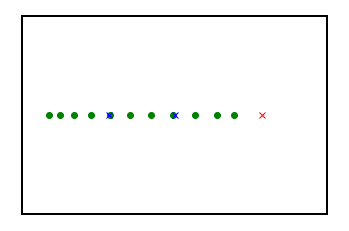

In [36]:
import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/easy_dense_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, path)


